In [1]:
from pathlib import Path
import os
import re
import html
import string

import unicodedata


import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data=pd.read_csv("/kaggle/input/amazon-reviews/test.csv",header=None)

In [3]:
data.head()

,0,1,2
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [4]:
data.columns=['polarity','title','text']

In [5]:
data.head()

,polarity,title,text
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [6]:
data.shape

(400000, 3)

In [7]:
data['review']=data['title']+" "+data['text']
data.head()

,polarity,title,text,review
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...,Great CD My lovely Pat has one of the GREAT vo...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,One of the best game music soundtracks - for a...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,Batteries died within a year ... I bought this...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,"works fine, but Maha Energy is better Check ou..."
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,Great for the non-audiophile Reviewed quite a ...


In [8]:
data['polarity']=data['polarity'].replace({2:1,1:0})
data.head()

,polarity,title,text,review
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...,Great CD My lovely Pat has one of the GREAT vo...
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,One of the best game music soundtracks - for a...
2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,Batteries died within a year ... I bought this...
3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,"works fine, but Maha Energy is better Check ou..."
4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,Great for the non-audiophile Reviewed quite a ...


In [9]:
from tqdm import tqdm
tqdm.pandas()

In [10]:
!pip install emoji
import emoji
# data['clean_review'] = data['review'].progress_apply(lambda x: emoji.demojize(x))
# data.head()
def demojize_safe(text):
    if isinstance(text, str):  # تحقق إذا كانت القيمة نصية
        return emoji.demojize(text)
    else:
        return "" 
data['review'] = data['review'].fillna('') 
data['clean_review'] = data['review'].progress_apply(demojize_safe)
data.head()

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


100%|██████████| 400000/400000 [02:15<00:00, 2943.63it/s]


,polarity,title,text,review,clean_review
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...,Great CD My lovely Pat has one of the GREAT vo...,Great CD My lovely Pat has one of the GREAT vo...
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,One of the best game music soundtracks - for a...,One of the best game music soundtracks - for a...
2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,Batteries died within a year ... I bought this...,Batteries died within a year ... I bought this...
3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,"works fine, but Maha Energy is better Check ou...","works fine, but Maha Energy is better Check ou..."
4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,Great for the non-audiophile Reviewed quite a ...,Great for the non-audiophile Reviewed quite a ...


In [11]:
def remove_digits(data):
    return re.sub(r'\d+', '', data)
    
data['clean_review'] = data['clean_review'].progress_apply(lambda x: remove_digits(x))
data.head()

100%|██████████| 400000/400000 [00:03<00:00, 108960.42it/s]


,polarity,title,text,review,clean_review
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...,Great CD My lovely Pat has one of the GREAT vo...,Great CD My lovely Pat has one of the GREAT vo...
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,One of the best game music soundtracks - for a...,One of the best game music soundtracks - for a...
2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,Batteries died within a year ... I bought this...,Batteries died within a year ... I bought this...
3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,"works fine, but Maha Energy is better Check ou...","works fine, but Maha Energy is better Check ou..."
4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,Great for the non-audiophile Reviewed quite a ...,Great for the non-audiophile Reviewed quite a ...


In [12]:
exclude = string.punctuation
exclude

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
def remove_punctuation(data):
    for char in exclude:
        data = data.replace(char,'')
    return data

data['clean_review'] =  data['clean_review'].progress_apply(lambda x: remove_punctuation(x))
data.head()

100%|██████████| 400000/400000 [00:03<00:00, 107298.27it/s]


,polarity,title,text,review,clean_review
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...,Great CD My lovely Pat has one of the GREAT vo...,Great CD My lovely Pat has one of the GREAT vo...
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,One of the best game music soundtracks - for a...,One of the best game music soundtracks for a ...
2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,Batteries died within a year ... I bought this...,Batteries died within a year I bought this ch...
3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,"works fine, but Maha Energy is better Check ou...",works fine but Maha Energy is better Check out...
4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,Great for the non-audiophile Reviewed quite a ...,Great for the nonaudiophile Reviewed quite a b...


In [15]:
data['clean_review'] = data['clean_review'].apply(lambda x: word_tokenize(x))
data['clean_review'].head()

0    [Great, CD, My, lovely, Pat, has, one, of, the...
1    [One, of, the, best, game, music, soundtracks,...
2    [Batteries, died, within, a, year, I, bought, ...
3    [works, fine, but, Maha, Energy, is, better, C...
4    [Great, for, the, nonaudiophile, Reviewed, qui...
Name: clean_review, dtype: object

In [16]:
StopWords = stopwords.words("english")
StopWords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [17]:
def remove_stopwords(text):
    return [word for word in text if word not in StopWords]
    
data['clean_review']=data['clean_review'].apply(lambda x:remove_stopwords(x))
data['clean_review'].head()

0    [Great, CD, My, lovely, Pat, one, GREAT, voice...
1    [One, best, game, music, soundtracks, game, I,...
2    [Batteries, died, within, year, I, bought, cha...
3    [works, fine, Maha, Energy, better, Check, Mah...
4    [Great, nonaudiophile, Reviewed, quite, bit, c...
Name: clean_review, dtype: object

In [19]:
from nltk.stem import PorterStemmer

ps=PorterStemmer()
def stem_words(text):
    return " ".join([ps.stem(word) for word in text])

data['clean_review'] = data['clean_review'].apply(lambda x:stem_words(x))
data['clean_review'].head()

0    great CD My love pat one great voic gener I li...
1    one best game music soundtrack game I didnt re...
2    batteri die within year I bought charger jul w...
3    work fine maha energi better check maha energi...
4    great nonaudiophil review quit bit combo playe...
Name: clean_review, dtype: object

In [23]:
from collections import Counter
sequences = [desc.split() for desc in data['clean_review']]
sequence_lengths = [len(seq) for seq in sequences]
length_counts = Counter(sequence_lengths)
lengths = list(length_counts.keys())
counts = list(length_counts.values())

In [24]:
length_counts.most_common(5)

[(18, 8182), (17, 8151), (16, 8039), (19, 7912), (20, 7884)]

In [26]:
vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(data['clean_review'])



In [21]:
import sklearn
from sklearn.model_selection import train_test_split 
x=data['clean_review']
y=data['polarity']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=42, stratify=y)

In [27]:
# Convert texts to sequences
x_train_seq = tok.texts_to_sequences(x_train)
x_test_seq = tok.texts_to_sequences(x_test)

In [29]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [30]:
classes_lb = lb.classes_
classes_lb

array([0, 1])

In [32]:
def get_max_len(texts):
  return max([len(word_tokenize(text)) for text in texts])

In [33]:
maxlen = get_max_len(data['clean_review'])

In [34]:
maxlen 

201

In [35]:
# Pad sequences to the same length
x_train = pad_sequences(x_train_seq, maxlen=maxlen, padding='post', truncating='post')  # Adjust `maxlen` as needed
x_test = pad_sequences(x_test_seq, maxlen=maxlen, padding='post', truncating='post')

In [36]:
print("First padded training sequence:", x_train[0])
print("First padded testing sequence:", x_test[0])

First padded training sequence: [  69  197 1068 3034   69  554  146   21  154    2   12   27    2  141
    2   61   30  306   52   22 4439  206  838   13 1054  433  232  106
    2   19  372   13   47    1 1256  838 2423 1297  121   12  353  860
  901 2495 1319 2495  901    1    1 5131 1319    1 2566 5131  106    1
    1 1763 8488   20  201  603 2096 1919  434   11 8289  390 5815  838
  308  901 1319   40 1907  463  127 1318 1878    2  183   99 1555  924
   12 8525   76  996  285    1  183   12  603 2096 1919    2    1   80
  296  124 2495 9368  145 1085  479  237 1786    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0

In [48]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

embedding_size = 100

# Model: Enhanced LSTM with multiple layers
model = Sequential()
model.add(Embedding(vocab_sz + 1, embedding_size, mask_zero=True, input_length=maxlen))

# Add LSTM layers with increased dropout
model.add(LSTM(64, return_sequences=True, recurrent_dropout=0.3, dropout=0.3))
model.add(Dropout(0.4))
model.add(LSTM(64, return_sequences=True, recurrent_dropout=0.3, dropout=0.3))
model.add(Dropout(0.4))
model.add(LSTM(64, recurrent_dropout=0.3, dropout=0.3))
model.add(Dropout(0.4))

# Add dense layers with regularization
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Output layer
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Model summary
model.summary()

# EarlyStopping callback
checkpoint = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)
callbacks_lst = [checkpoint]

# Train the model
history = model.fit(
    x_train, y_train,
    batch_size=256,
    epochs=50,  # Adjust epochs to see results
    validation_split=0.2,
    callbacks=callbacks_lst
)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 668s 663ms/step - accuracy: 0.8031 - loss: 0.5383 - val_accuracy: 0.8811 - val_loss: 0.3023
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 664s 664ms/step - accuracy: 0.8856 - loss: 0.2911 - val_accuracy: 0.8936 - val_loss: 0.2602
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 665s 665ms/step - accuracy: 0.8992 - loss: 0.2571 - val_accuracy: 0.9013 - val_loss: 0.2457
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 665s 665ms/step - accuracy: 0.9084 - loss: 0.2361 - val_accuracy: 0.9040 - val_loss: 0.2406
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 723s 723ms/step - accuracy: 0.9159 - loss: 0.2169 - val_accuracy: 0.9054 - val_loss: 0.2349
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 715s 715ms/step - accuracy: 0.9226 - loss: 0.2034 - val_accuracy: 0.9087 - val_loss: 0.2333
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 667s 667ms/step - accuracy: 0.9275 - loss: 0.1922 - val_accuracy: 0.9061 - val_loss: 0.2389
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 658s 658ms/step - ac

In [46]:
checkpoint = EarlyStopping(monitor='val_accuracy',patience = 10 ,mode='max')
callbacks_lst = [checkpoint]

In [52]:
model.evaluate(x_test,y_test)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 451s 180ms/step - accuracy: 0.9086 - loss: 0.2358


[0.23579861223697662, 0.9080250263214111]

In [51]:
model.evaluate(x_train,y_train)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1798s 180ms/step - accuracy: 0.9358 - loss: 0.1695


[0.1814611852169037, 0.930899977684021]

In [53]:
y_pred = model.predict(x_test).argmax(axis=-1)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 449s 179ms/step


In [56]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

classes_lb = ['Class 0', 'Class 1'] 

report = classification_report(y_test, y_pred, target_names=classes_lb)
print(report)



              precision    recall  f1-score   support

     Class 0       0.92      0.89      0.91     40000
     Class 1       0.90      0.92      0.91     40000

    accuracy                           0.91     80000
   macro avg       0.91      0.91      0.91     80000
weighted avg       0.91      0.91      0.91     80000



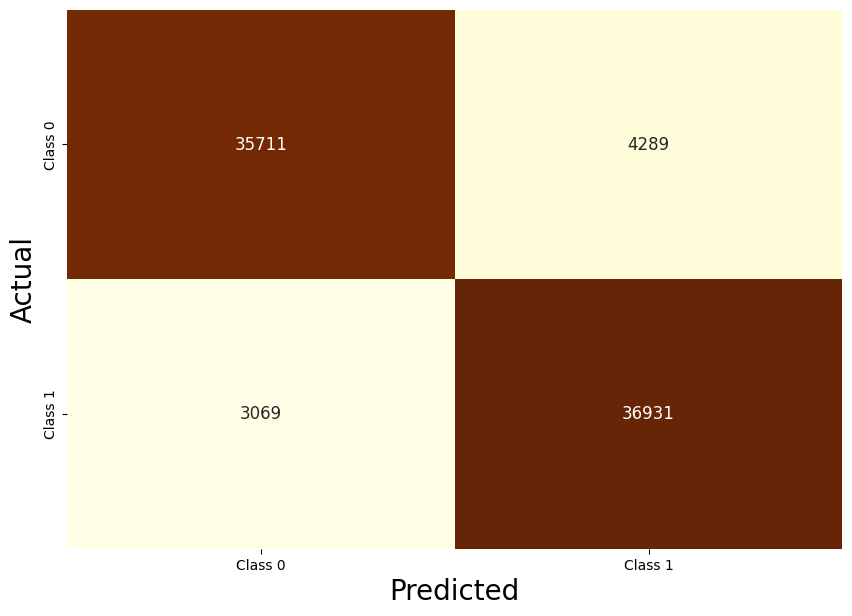

In [57]:
disp = confusion_matrix(y_test, y_pred)
disp.astype('int')
df_cm = pd.DataFrame(disp, classes_lb, classes_lb)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_cm, annot=True, annot_kws={"size":12},ax=ax, cmap="YlOrBr", fmt='g',cbar=False) #font
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.show()
